In [37]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

# Считываем данные

In [2]:
r = np.genfromtxt("4ecoli_with_pure_samples/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("4ecoli_with_pure_samples/matrices/X_all", dtype=int, delimiter=' ')
print("%s sites" % len(r))

119292 sites


Читаем маску и удаляем первые 4 колонки:

In [3]:
mask = x[:, 0:4]
mask[mask > 0] = 1

r = np.delete(r, [0, 1, 2, 3], axis=1)
x = np.delete(x, [0, 1, 2, 3], axis=1)

## Фильтрация и преобразование

Удаляем снипы с покрытием, близким к 0 или 1:

In [4]:
Ncut = 5
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
110044 remained


#### Нормализация
Берем либо вектор VAF, либо вектор (1 - VAF) в зависимости от того, чья норма больше.

In [6]:
def normalize(x, r):
    M = np.divide(x, r)
    M_norm = np.full_like(M, 0)
    for i in range(np.shape(M)[0]):
        rev = 1 - M[i, :]
        if np.dot(M[i, :], M[i, :]) > np.dot(rev, rev):
            M_norm[i, :] = rev
        else:
            M_norm[i, :] = M[i, :]
    return M_norm

f = normalize(x, r)

Рисуем получившиеся фичи на главных компонентах.

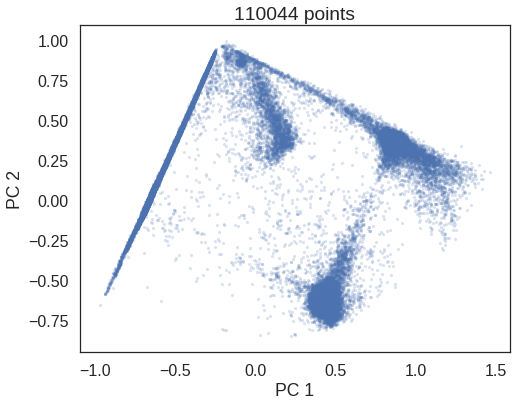

In [7]:
def draw_PCA(f_pca, black_points=None):
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=10, linewidth=0, alpha=0.2);
    if black_points is not None:
        plt.scatter(f_pca[black_points, 0], f_pca[black_points, 1], s=10, linewidth=0, c="black", alpha=1);
        plt.title("%s/%s points" % (np.sum(black_points), len(f_pca)))
    else:
        plt.title("%s points" % len(f_pca))


f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca)

Отметим те точки, у которых неплохое покрытие по R. (Но пока их выкидывать не будем.)

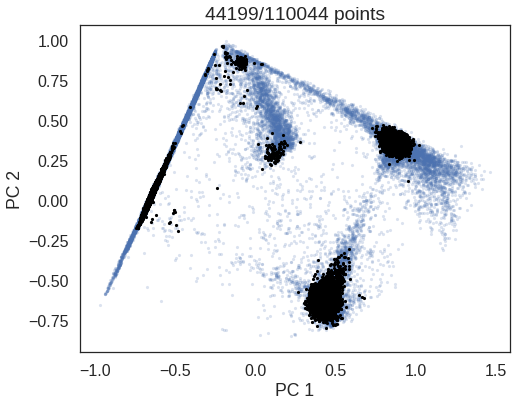

In [8]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

# Рисуем картинки

(Вспомогательная процедура, которая рисует легенду с обозначением цветов.)

In [10]:
def draw_legend(class_colours, classes, right=False):
    recs = []
    for i in range(0, len(classes)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    if right:
        plt.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(recs, classes)

## Уникальные и не очень SNP

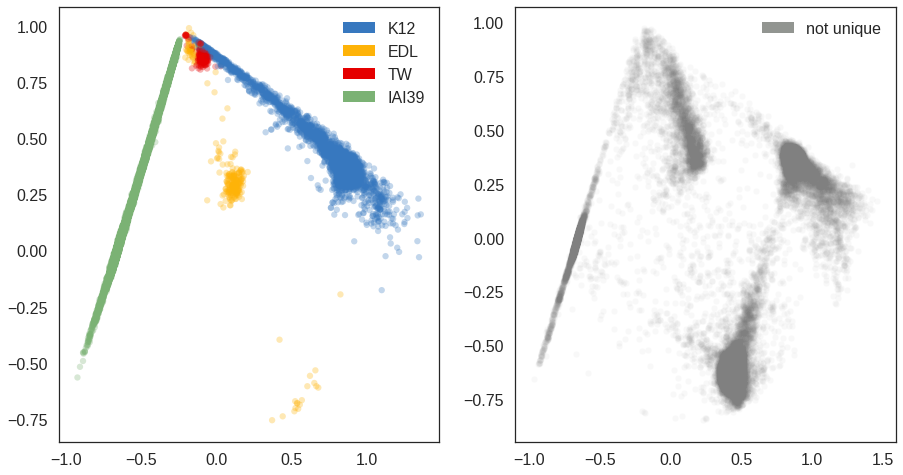

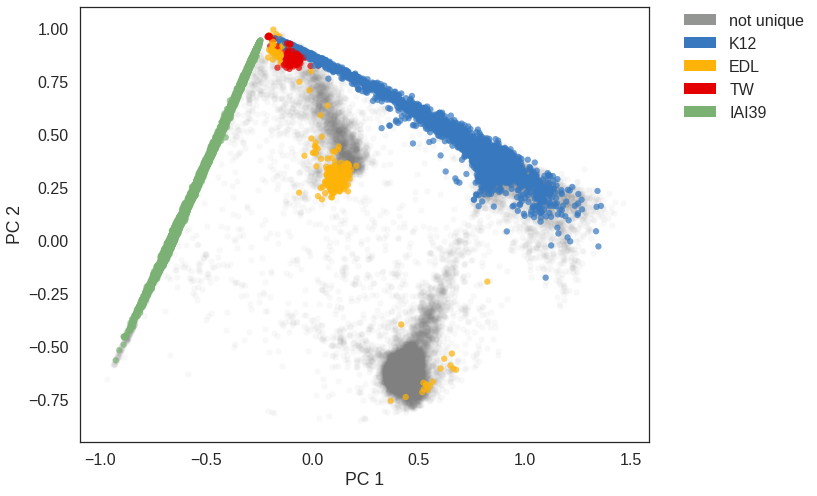

In [25]:
names = ["K12", "EDL", "TW", "IAI39"]

def plot_unique_and_not(f_pca, mask, names):
    unique = []
    for m in mask:
        if np.sum(m) == 1:
            index = np.where(m == 1)[0][0]
            unique.append(index)
        else:
            unique.append(-1)

    # split data in 2 groups
    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'unique':unique})
    df_not_unique = df.loc[df['unique'] == -1]
    df_unique = df.loc[df['unique'] != -1]

    colors = ["windows blue", "amber", "red", "faded green", "dusty purple"]
    color_palette = sns.xkcd_palette(colors)
    cluster_colors = [color_palette[x] for x in df_unique["unique"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    # only uniques
    plt.subplot(1, 2, 1)
    plt.scatter(df_unique["pc1"], df_unique["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.3);
    draw_legend(color_palette, names)
    # only non-uniques
    plt.subplot(1, 2, 2)
    plt.scatter(df_not_unique["pc1"], df_not_unique["pc2"], s=40, linewidth=0, c="grey", alpha=0.05)
    draw_legend(sns.xkcd_palette(["grey"]), ["not unique"])

    # both types
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.scatter(df_not_unique["pc1"], df_not_unique["pc2"], s=40, linewidth=0, c="grey", alpha=0.05)
    plt.scatter(df_unique["pc1"], df_unique["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.7);
    draw_legend(sns.xkcd_palette(["grey"] + colors), ["not unique"] + names, right=True)
    
plot_unique_and_not(f_pca, mask, names)

## В сколькиx стрейнах встречается SNP

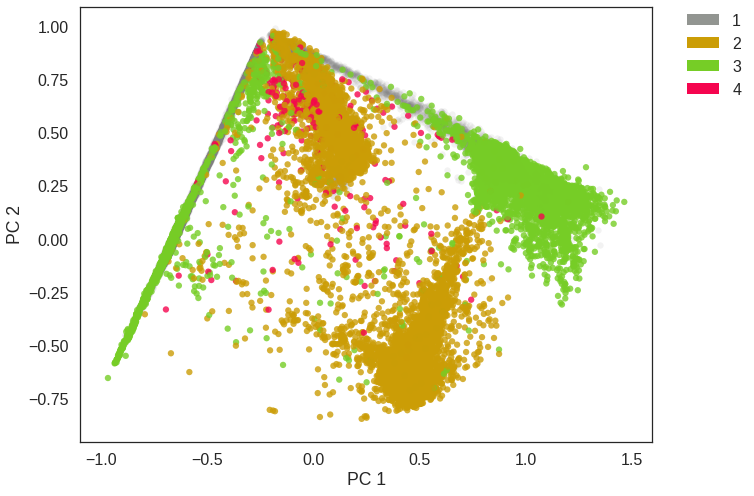

In [32]:
def plot_how_much_strains(f_pca, mask):
    num_of_strains = len(mask[0])
    counts = [np.sum(m) for m in mask]

    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'counts':counts})
    df_not_unique = df.loc[df['counts'] > 1]
    df_unique = df.loc[df['counts'] == 1]

    colors = ["grey", "yellow ochre", "apple green", "pink red"]
    color_palette = sns.xkcd_palette(colors)
    cluster_colors = [color_palette[x - 1] for x in df_not_unique["counts"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(df_unique["pc1"], df_unique["pc2"], s=40, linewidth=0, c="grey", alpha=0.1)
    plt.scatter(df_not_unique["pc1"], df_not_unique["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.8);
    draw_legend(color_palette, [str(i) for i in range(1, num_of_strains+1)], right=True)
    
plot_how_much_strains(f_pca, mask)

## SNP, встречающиеся в комбинации стрейнов

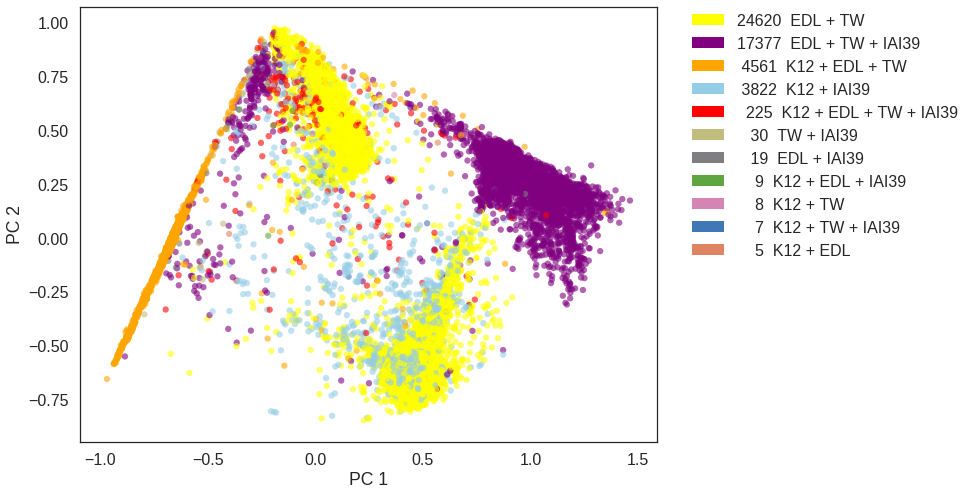

In [40]:
 def plot_shared_snps(f_pca, mask, names, draw_all=False):
    combs = []
    combs_nums = []
    combinations = []

    for m in mask:
        if not draw_all:
            if not (np.sum(m) > 1):
                combinations.append(-1)
                continue
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i]                    
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1
        combinations.append(combs.index(cur))

    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'combination':combinations})
    df_valid = df.loc[df['combination'] != -1]

    # reoder combinations by sizes of groups
    order = sorted(zip(combs_nums, combs, range(12)), reverse=True)
    new_comb_order = [0] * (2 ** len(mask[0]))
    new_comb_names = [] 
    for i in range(len(order)):
        old_order = order[i][2]
        new_comb_order[old_order] = i
        new_comb_names.append('{:5d}'.format(order[i][0]) + '  ' + order[i][1])
    for i in df_valid.index:
        df_valid.loc[i, "combination"] = new_comb_order[df_valid.loc[i, "combination"]]

    # Kelly’s 20 (except the first 2) Colours of Maximum Contrast
    colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    color_palette = sns.color_palette(colors)
    cluster_colors = [color_palette[x] for x in df_valid["combination"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.scatter(df_valid["pc1"], df_valid["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.6);
    draw_legend(color_palette, new_comb_names, right=True)
    
plot_shared_snps(f_pca, mask, names)

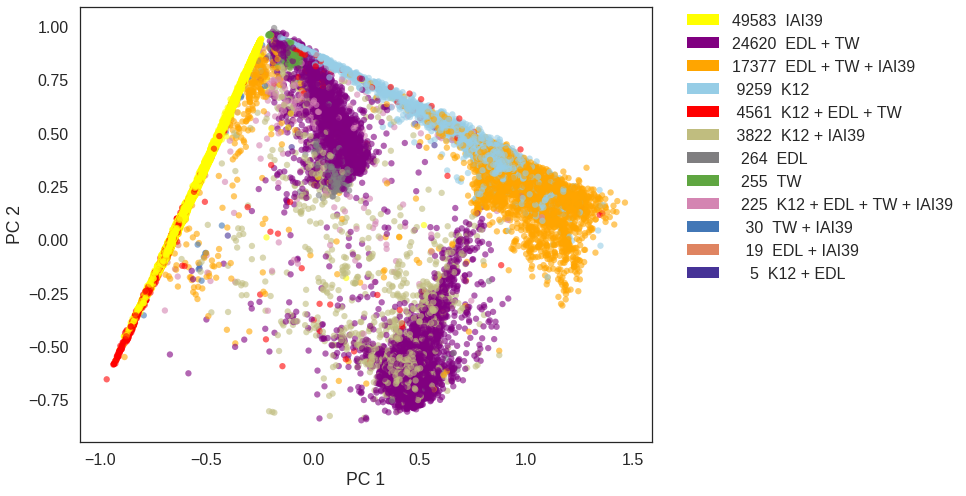

In [41]:
plot_shared_snps(f_pca, mask, names, draw_all=True)

# Без преобразования

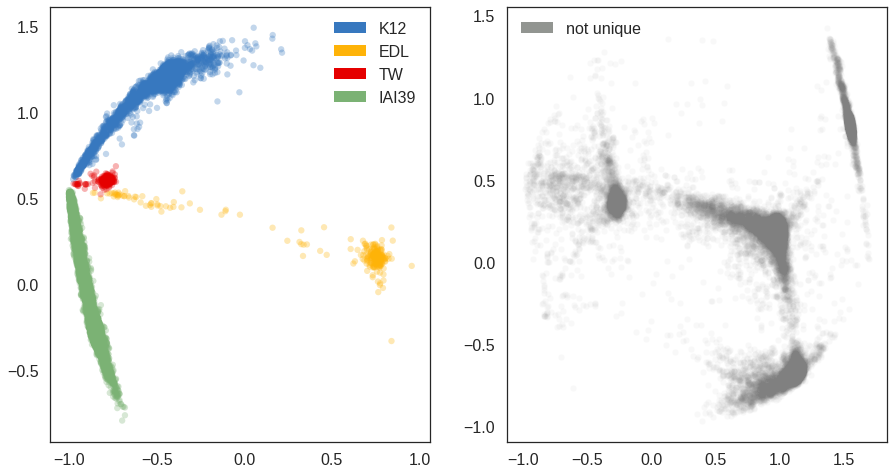

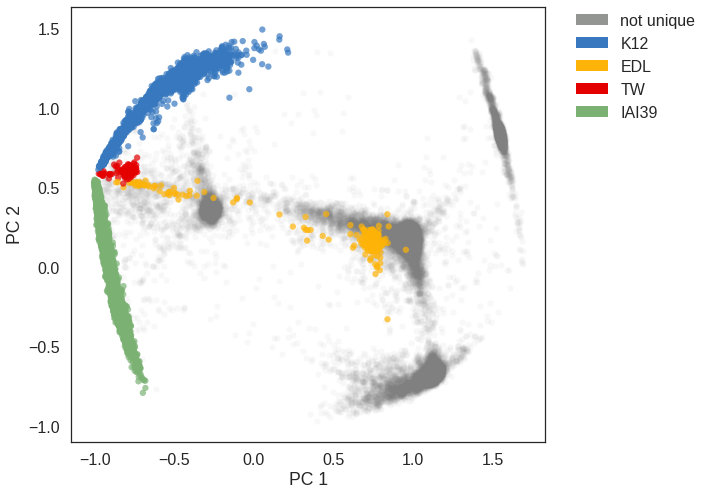

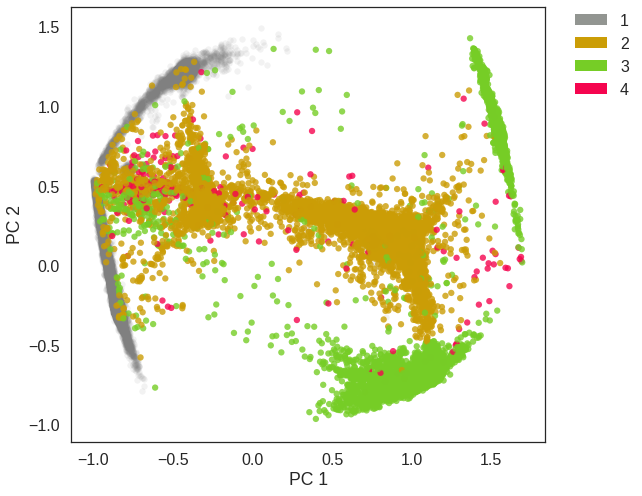

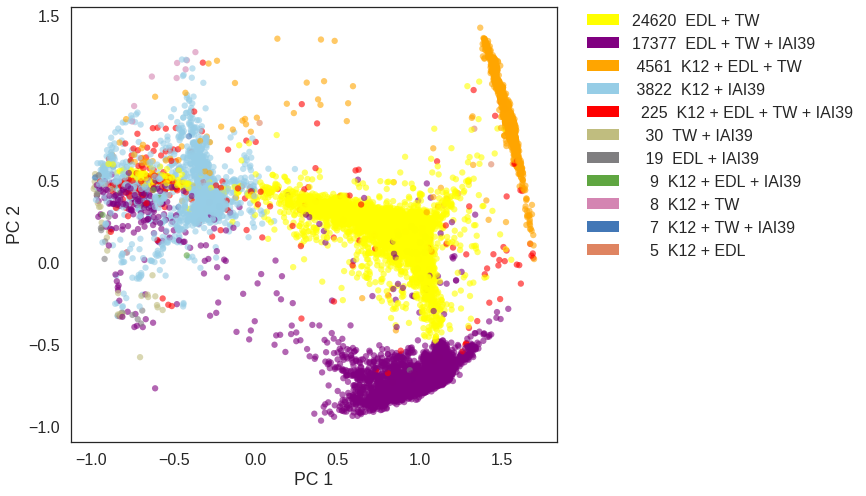

In [33]:
f_withoutT = np.divide(x, r)
f_pca_withoutT = PCA(n_components=2).fit(f_withoutT).transform(f_withoutT)

plot_unique_and_not(f_pca_withoutT, mask, names)
plot_how_much_strains(f_pca_withoutT, mask)
plot_shared_snps(f_pca_withoutT, mask, names)

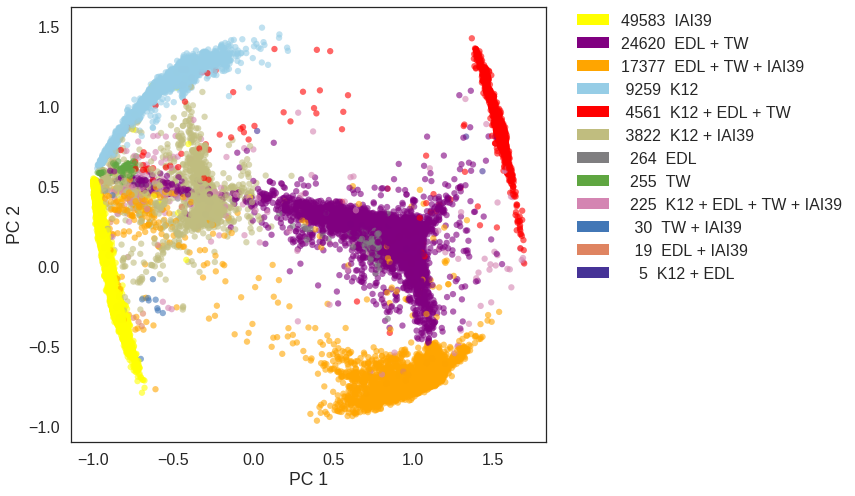

In [42]:
plot_shared_snps(f_pca_withoutT, mask, names, draw_all=True)

# С фильтрацией по покрытию

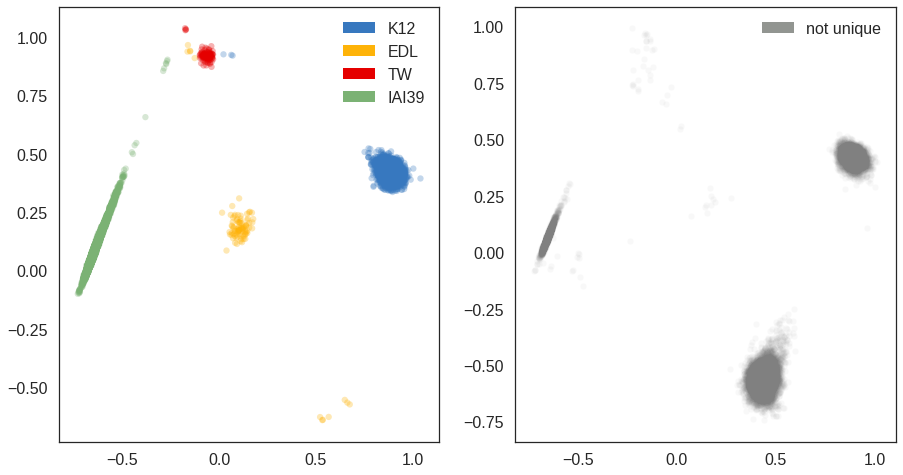

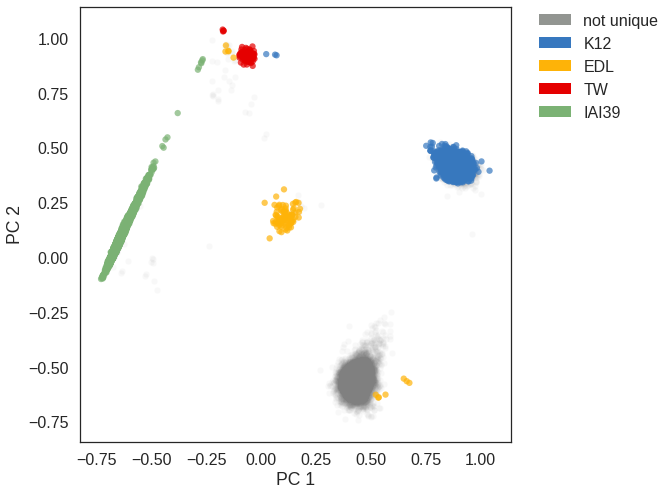

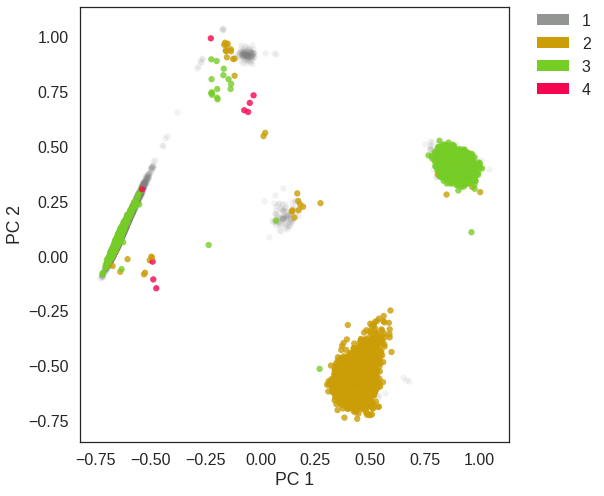

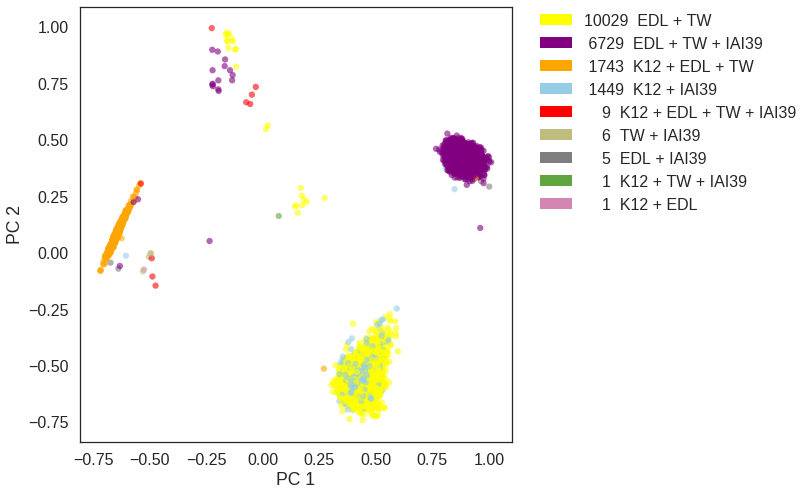

In [34]:
good_coverage = filter_by_coverage(r, 15, 2)

f_filtered = normalize(x, r)[good_coverage, :]
mask_filtered = mask[good_coverage, :]

f_pca_filtered = PCA(n_components=2).fit(f_filtered).transform(f_filtered)

plot_unique_and_not(f_pca_filtered, mask_filtered, names)
plot_how_much_strains(f_pca_filtered, mask_filtered)
plot_shared_snps(f_pca_filtered, mask_filtered, names)

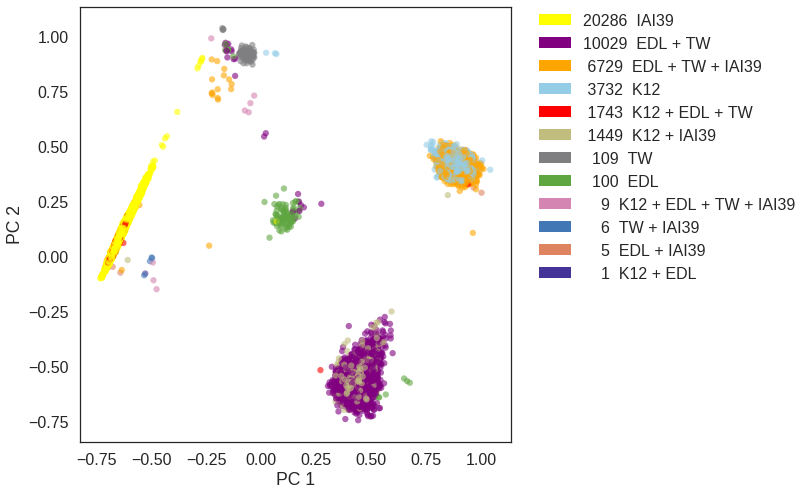

In [43]:
plot_shared_snps(f_pca_filtered, mask_filtered, names, draw_all=True)

# С фильтрацией по покрытию и без преобразования

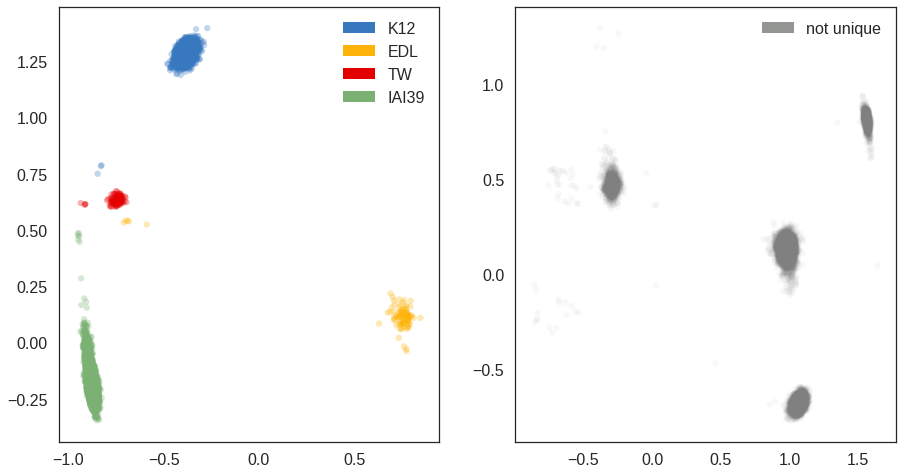

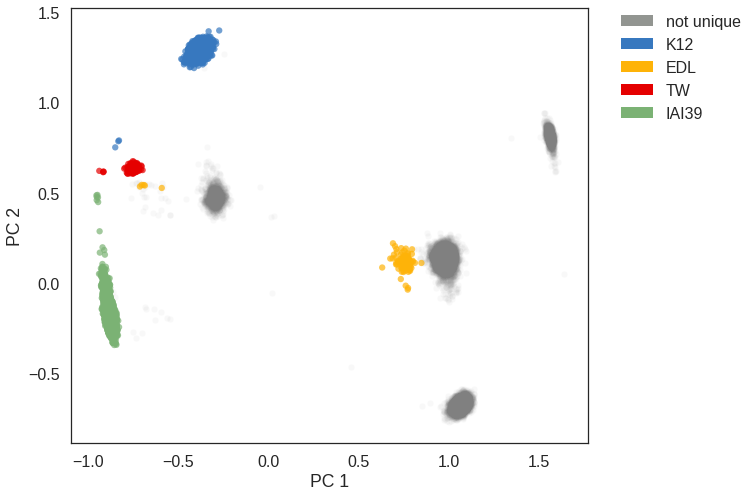

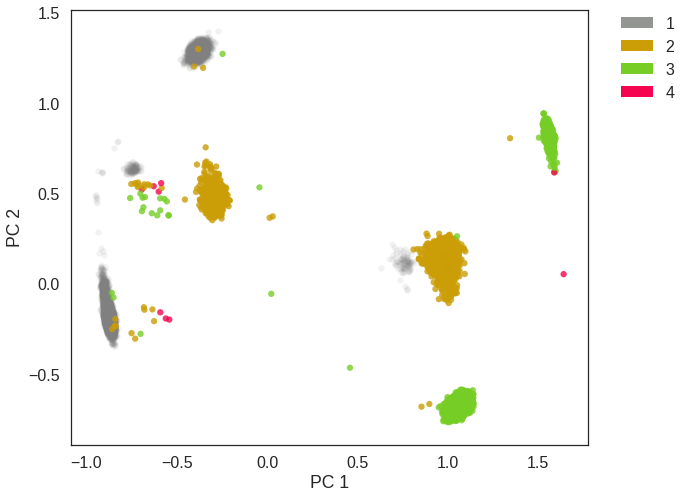

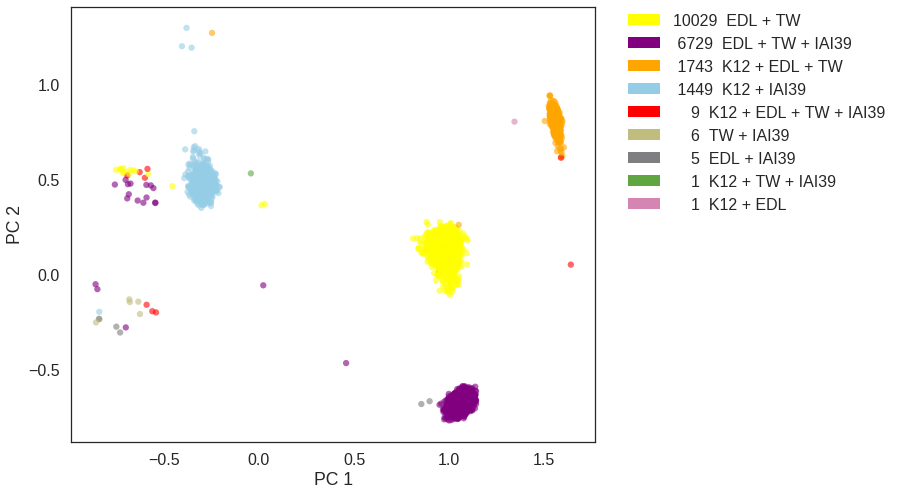

In [35]:
f_withoutT_filtered = np.divide(x, r)[good_coverage, :]

f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

plot_unique_and_not(f_pca_withoutT_filtered, mask_filtered, names)
plot_how_much_strains(f_pca_withoutT_filtered, mask_filtered)
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names)

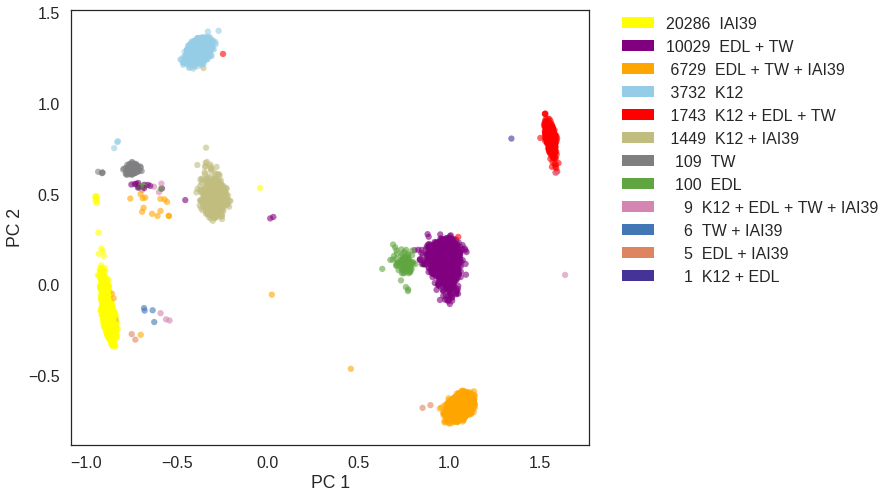

In [44]:
plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, draw_all=True)

## Размеры групп

In [55]:
 def sizes_of_groups(mask, names):
    combs = []
    combs_nums = []

    for m in mask:
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i]                    
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1

    df = pd.DataFrame({'size':combs_nums, 'description':combs})
    df = df.sort_values(by='size', ascending=False)
    df = df.reset_index(drop=True)
    return df

##### Нефильтрованные данные:

In [58]:
sizes_of_groups(mask, names)

,description,size
0,IAI39,49583
1,EDL + TW,24620
2,EDL + TW + IAI39,17377
3,K12,9259
4,K12 + EDL + TW,4561
5,K12 + IAI39,3822
6,EDL,264
7,TW,255
8,K12 + EDL + TW + IAI39,225
9,TW + IAI39,30


##### Фильтрованные:

In [57]:
sizes_of_groups(mask_filtered, names)

,description,size
0,IAI39,20286
1,EDL + TW,10029
2,EDL + TW + IAI39,6729
3,K12,3732
4,K12 + EDL + TW,1743
5,K12 + IAI39,1449
6,TW,109
7,EDL,100
8,K12 + EDL + TW + IAI39,9
9,TW + IAI39,6
